In [1]:
import os
import xarray as xr
import geopandas as gp
import pandas as pd
import numpy as np
import sparse

import hvplot.pandas
import hvplot.xarray
import dask
import cf_xarray

from pynhd import NLDI, WaterData
import intake
import cartopy.crs as ccrs
from shapely.geometry import Polygon

import time
import dask
import requests
from dask.distributed import Client

import requests
from IPython.display import HTML
import warnings
from IPython.display import HTML

from pynhd import NLDI, WaterData
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

warnings.filterwarnings("ignore", category=FutureWarning, module="geopandas")

In [2]:
# open the hytest data intake catalog
hytest_cat = intake.open_catalog("https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml")
list(hytest_cat)

['conus404-catalog',
 'conus404-drb-eval-tutorial-catalog',
 'nhm-v1.0-daymet-catalog',
 'nhm-v1.1-c404-bc-catalog',
 'nhm-v1.1-gridmet-catalog',
 'trends-and-drivers-catalog',
 'nhm-prms-v1.1-gridmet-format-testing-catalog',
 'nwis-streamflow-usgs-gages-onprem',
 'nwis-streamflow-usgs-gages-osn',
 'nwm21-streamflow-usgs-gages-onprem',
 'nwm21-streamflow-usgs-gages-osn',
 'nwm21-streamflow-cloud',
 'geofabric_v1_1-zip-osn',
 'geofabric_v1_1_POIs_v1_1-osn',
 'geofabric_v1_1_TBtoGFv1_POIs-osn',
 'geofabric_v1_1_nhru_v1_1-osn',
 'geofabric_v1_1_nhru_v1_1_simp-osn',
 'geofabric_v1_1_nsegment_v1_1-osn',
 'gages2_nndar-osn',
 'wbd-zip-osn',
 'huc12-geoparquet-osn',
 'huc12-gpkg-osn',
 'nwm21-scores',
 'lcmap-cloud',
 'rechunking-tutorial-osn',
 'pointsample-tutorial-sites-osn',
 'pointsample-tutorial-output-osn']

In [3]:

# open the conus404 sub-catalog
# cat = hytest_cat['conus404-catalog']

cat = hytest_cat['nhm-v1.1-gridmet-catalog']

list(cat)


['nhm-v1.1-gridmet-byHRU-onprem',
 'nhm-v1.1-gridmet-byHW-onprem',
 'nhm-v1.1-gridmet-byHWobs-onprem']

In [4]:
## Select the dataset you want to read into your notebook and preview its metadata
#  conus404-daily-osn
dataset = 'nhm-v1.1-gridmet-byHW-onprem' 
cat[dataset]

nhm-v1.1-gridmet-byHW-onprem:
  args:
    consolidated: false
    storage_options:
      fo: /caldera/hovenweep/projects/usgs/water/impd/hytest/nhm/nhm_v1.1/gm_byHW/nhm_v1.1_gm_byHW_combined.json
    urlpath: reference://
  description: National Hydrologic Model version 1.1 model output variables using
    by-headwater calibrated parameters with gridmet forcings
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/subcatalogs


In [5]:
print(f"Reading {dataset} metadata...", end='')
ds = cat[dataset].to_dask().metpy.parse_cf()
print("done")


Reading nhm-v1.1-gridmet-byHW-onprem metadata...

C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


FileNotFoundError: [Errno 2] No such file or directory: 'C:/caldera/hovenweep/projects/usgs/water/impd/hytest/nhm/nhm_v1.1/gm_byHW/nhm_v1.1_gm_byHW_combined.json/.zmetadata'

In [6]:

# # Define the function to load the dataset with retries
# def load_dataset_with_retries(cat, dataset, retries=3, delay=5):
#     for attempt in range(retries):
#         try:
#             ds = cat[dataset].to_dask()
#             return ds
#         except (requests.exceptions.Timeout, requests.exceptions.ConnectionError) as e:
#             print(f"Attempt {attempt + 1} failed: {e}")
#             if attempt < retries - 1:
#                 time.sleep(delay)
#             else:
#                 raise e
#         except KeyError as ke:
#             print(f"KeyError: {ke}")
#             raise ke
#         except Exception as ex:
#             print(f"Unexpected error: {ex}")
#             raise ex

# # Example usage
# try:
#     ds = load_dataset_with_retries(cat, 'conus404-daily-osn')
# except Exception as e:
#     print(f"Failed to load dataset: {e}")

# ds = cat['conus404-daily-osn'].to_dask()
# ds = cat[dataset].to_dask()

# def get_usgs_gage_ids(state_code):
#     url = f'https://waterservices.usgs.gov/nwis/site/?format=rdb&stateCd={state_code}&siteType=ST&siteStatus=active'

#     try:
#         response = requests.get(url)
#         if response.status_code == 200:
#             lines = response.text.split('\n')
#             data_lines = [line for line in lines if not line.startswith('#')]
#             gage_ids = [line.split('\t')[1] for line in data_lines if line.strip()]
#             return gage_ids
#         else:
#             print(f"Failed to fetch data. Status code: {response.status_code}")
#             return None
#     except Exception as e:
#         print(f"An error occurred: {str(e)}")
#         return None

# delaware_gage_ids = get_usgs_gage_ids('IA')

# html_table = "<table>"
# html_table += "<tr><th>USGS Gage IDs for Iowa</th></tr>"
# for gage_id in delaware_gage_ids:
#     html_table += f"<tr><td>{gage_id}</td></tr>"
# html_table += "</table>"

# HTML(html_table)


# Define the function to load the dataset with retries
def load_dataset_with_retries(cat, dataset, retries=3, delay=5):
    for attempt in range(retries):
        try:
            ds = cat[dataset].to_dask()
            return ds
        except (requests.exceptions.Timeout, requests.exceptions.ConnectionError) as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
            else:
                raise e
        except KeyError as ke:
            print(f"KeyError: {ke}")
            raise ke
        except Exception as ex:
            print(f"Unexpected error: {ex}")
            raise ex

# Example usage
try:
    ds = load_dataset_with_retries(cat, 'conus404-daily-osn')
except Exception as e:
    print(f"Failed to load dataset: {e}")

def get_usgs_gage_ids(state_code):
    url = f'https://waterservices.usgs.gov/nwis/site/?format=rdb&stateCd={state_code}&siteType=ST&siteStatus=active'

    try:
        response = requests.get(url)
        if response.status_code == 200:
            lines = response.text.split('\n')
            data_lines = [line for line in lines if not line.startswith('#')]
            gage_data = [line.split('\t') for line in data_lines if line.strip()]
            gage_info = [{"id": data[1], "state": data[2]} for data in gage_data if len(data) > 2]
            return gage_info
        else:
            print(f"Failed to fetch data. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

iowa_gage_info = get_usgs_gage_ids('IA')

if iowa_gage_info:
    html_table = "<table border='1'>"
    html_table += "<tr><th>USGS Gage IDs</th><th>State</th></tr>"
    for gage in iowa_gage_info:
        html_table += f"<tr><td>{gage['id']}</td><td>{gage['state']}</td></tr>"
    html_table += "</table>"

    display(HTML(html_table))
else:
    print("No gage IDs found or failed to fetch data.")

USGS Gage IDs,State
site_no,station_nm
15s,50s
05387320,"Upper Iowa River at Lime Springs, IA"
05387405,"Upper Iowa River at Kendallville, IA"
05387440,"Upper Iowa River at Bluffton, IA"
05387500,"Upper Iowa River at Decorah, IA"
05388250,"Upper Iowa River near Dorchester, IA"
05388310,"Waterloo Creek near Dorchester, IA"
05389000,"Yellow River near Ion, IA"
05389015,"Yellow R at Effigy Mounds NM nr Harpers Ferry, IA"


In [7]:
# gage_id = ['05470000', '05470500']
gage_id = ['422958090391101', '05387405', '05389015', '05387500', '05388250', '05388310', '05389000', '05389015', '05389400', '05389500', '05411500', '05411600', 
    '05411850', '05412020', '05412400', '05412500', '05414400', '05414700', 
    '05416900', '05418400', '05418500', '05420460', '05420500', '05420680', 
    '05420850', '05421000', '05421740', '05421890', '05422000', '05422405', 
    '05422410', '05422470', '05422600', '05422620', '05448400', '05449500', 
    '05450400', '05451080', '05451210', '0545129280', '05451500', '05451700', 
    '05451770', '05451900', '05451955', '05452000', '05452200', '05452500', 
    '05453000', '05453100', '05453200', '05453520', '05454000', '05454090', 
    '05454220', '05454300', '05454500', '05455010', '05455100', '05455230', 
    '05455500', '05455700', '05457440', '05457700', '05458000', '05458300', 
    '05458500', '05458900', '05459490', '05459500', '05460100', '05462000', 
    '05463000', '05463050', '05463500', '05464000', '05464220', '05464315', 
    '05464420', '05464475', '05464480', '05464500', '05464695', '05464730', 
    '05464780', '0546494170', '05465000', '05465100', '05465500', '05465700', 
    '05469350', '05469860', '05469990', '05470000', '05470500', '05471000', 
    '05471050', '05471200', '05471500', '05472390', '05472500', '05472555', 
    '05473400', '05473450', '05474000', '05474500', '05476500', '05476590', 
    '05476735', '05476750', '05478265', '05479000', '05480080', '05480500', 
    '05480820', '05480930', '05481000', '05481300', '05481510', '05481530', 
    '05481650', '05481950', '05482000', '05482300', '05482430', '05482500', 
    '05483318', '05483349', '05483450', '05483600', '05484000', '05484500', 
    '05484600', '05484650', '05484800', '05484900', '05485500', '05485605', 
    '05485640', '05486000', '05486490', '05487470', '05487520', '05487980', 
    '05488110', '05488200', '05488500', '05489000', '05489200', '05489490', 
    '05489500', '05490500', '06483290', '06483495', '06483500', '06485500', 
    '06485950', '06599900', '06599950', '06600000', '06600030', '06600100', 
    '06600500', '06601200', '06602020', '06602190', '06602400', '06605000', 
    '06605340', '06605750', '06605850', '06606600', '06607200', '06607500', 
    '06608500', '06609500', '06609560', '06610505', '06807410', '06808500', 
    '06809210', '06809500', '06810000', '06811760', '06811800', '06811875', 
    '06816290', '06817000', '06817300', '06819185', '06898000', '06903400', 
    '06903700', '06903900', '06903990', '06904010', '402351091222701', 
    '404753091053001', '405256091012601', '412327091031801', '412957090371001', 
    '413428090241101', '415143091431601', '415236091432401', '421539090252101', 
    '422958090391101']

nldi = NLDI()
del_basins = nldi.get_basins(gage_id)
wbd12 = WaterData('wbd08')
huc12_basins = wbd12.bygeom(del_basins.geometry[0])


C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\pynhd\pynhd.py:1141: UserWarning: 7 of 206 requests failed.. Indices of the failed requests are [2, 7, 101, 196, 202, 203, 204]
  index, resp = self._get_urls(urls, True)


In [8]:
%%time
# gage_id = ['05470000', '05470500']
gage_id = [
    '05389015', '05470500' 
]

nldi = NLDI()
del_basins = nldi.get_basins(gage_id)
huc8_basins = WaterData('wbd08').bygeom(del_basins.geometry[0])

C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\pynhd\pynhd.py:1141: UserWarning: 1 of 2 requests failed.. Indices of the failed requests are [0]
  index, resp = self._get_urls(urls, True)


CPU times: total: 2.11 s
Wall time: 3.39 s


In [9]:
regions_df = huc8_basins
region_name = 'name'

<Axes: >

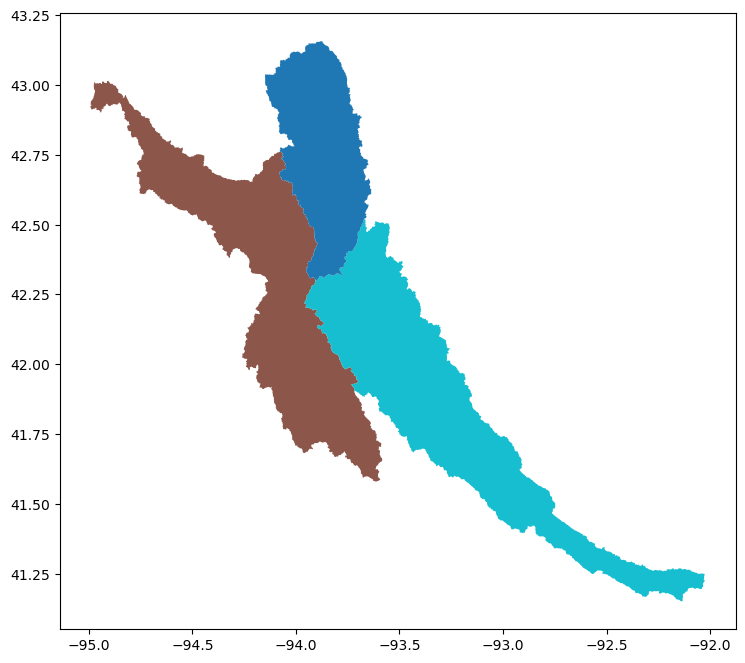

In [10]:
regions_df.plot(column=region_name, figsize=(12,8))

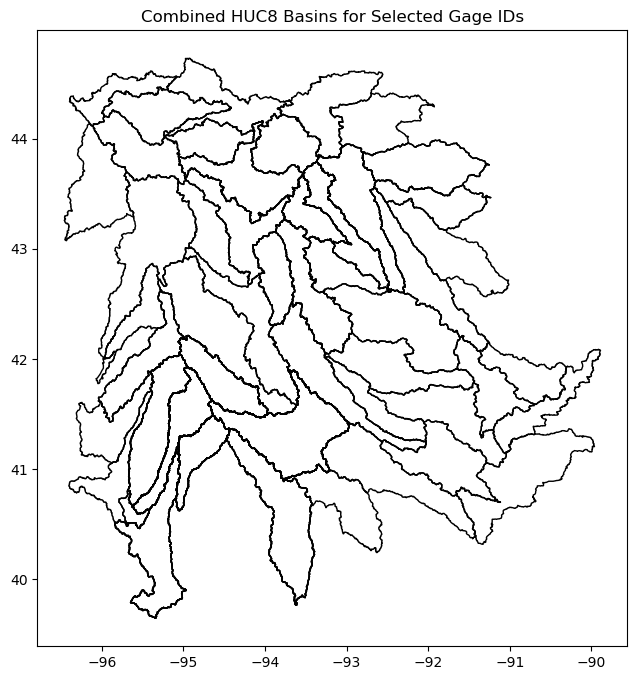

CPU times: total: 27.8 s
Wall time: 33.7 s


,geometry,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,gnis_id,areaacres,areasqkm,states,huc8,name,globalid
0,"MULTIPOLYGON (((-92.49978 43.62638, -92.49858 ...",{342979AC-90B2-4197-A662-8F96F2E3F98B},None,None,None,None,2012-06-11T07:54:56Z,None,639677.18,2588.68,"IA,MN",07060002,Upper Iowa,{D1E1D77D-2A7E-4DDF-B90F-18865C25B5FB}
1,"MULTIPOLYGON (((-92.20766 43.45717, -92.20740 ...",{5F37CEFE-0361-453D-BE80-A71DB9CD1EF6},None,None,None,None,2012-06-11T07:54:56Z,None,1084109.94,4387.24,IA,07060004,Turkey,{75E01900-FBB8-4E8A-88DD-1F9A3BC58AEF}
2,"MULTIPOLYGON (((-92.99137 43.95035, -92.99055 ...",{6AE5D8A8-3316-49A6-B484-84B00A70076D},None,None,None,None,2012-06-11T07:54:56Z,None,1078114.47,4362.98,"IA,MN",07080201,Upper Cedar,{259068D1-22E3-4C64-BAF0-DF508E1BF5B4}
3,"MULTIPOLYGON (((-91.85773 43.98620, -91.85592 ...",{7598E13E-2260-492E-9B43-ECFD7EBC0B11},None,None,None,None,2017-02-01T00:52:30Z,None,1065066.19,4310.17,"IA,MN",07040008,Root,{459C99D0-9807-4500-8C88-4938C6D68AE5}
4,"MULTIPOLYGON (((-92.65361 43.54975, -92.65215 ...",{D3C57FE4-D26B-46B6-B387-EAB1A96A2CF0},None,None,None,None,2012-06-11T07:54:56Z,None,1003377.82,4060.53,"IA,MN",07080102,Upper Wapsipinicon,{0FFC5DCE-0EC4-41FE-B4E1-440F7BE6546F}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"MULTIPOLYGON (((-91.99138 41.44409, -91.98991 ...",{D6567D53-25C9-4F9D-9848-7A6CD56F39B3},None,None,None,None,2012-06-11T07:54:56Z,None,1045531.64,4231.12,IA,07080107,Skunk,{F09F9D96-A976-4B34-AA1E-6E01B8B0A617}
89,"MULTIPOLYGON (((-93.36043 43.78841, -93.35986 ...",{D911D322-0667-4C87-9505-EC11E48345D3},None,None,None,None,2012-06-11T07:54:56Z,None,691348.09,2797.79,"IA,MN",07080202,Shell Rock,{7A1231C8-EEBA-4676-9D06-C1E04F658922}
90,"MULTIPOLYGON (((-93.75647 43.26474, -93.75607 ...",{ECE669E9-D814-4A42-9574-B61B0BEEF0E1},None,None,None,None,2012-06-11T07:54:56Z,None,931827.10,3770.97,IA,07080207,Upper Iowa,{DCAA8C3B-2731-4C07-914B-EA8DCD3035B2}
91,"MULTIPOLYGON (((-93.21937 42.02337, -93.21912 ...",{F5482012-4FCC-45A0-9DC5-71524F3980F0},None,None,None,None,2012-06-11T07:54:56Z,None,558361.16,2259.61,IA,07080106,North Skunk,{230E46FF-0656-418C-9612-78991A56381F}


In [11]:
%%time
# List of gage IDs
gage_ids = [
    '05387320', '05457440', '05459490','05486490', '05487470', '05487520', '05487980','06809210', '06809500', '06810000', '06811760', '06811800', '05465700',
#     '05387405', '05387440', '05387500', '05388250', '05388310', '05464220', '05470000', '05455700',
#     '05389000', '05389015', '05389400', '05389500', '05411500', '05411600', 
#     '05411850', '05412020', '05412400', '05412500', '05414400', '05414700', 
#     '05416900', '05418400', '05418500', '05420460', '05420500', '05420680', 
#     '05420850', '05421000', '05421740', '05421890', '05422000', '05422405', 
#     '05422410', '05422470', '05422600', '05422620', '05448400', '05449500', 
#     '05450400', '05451080', '05451210', '0545129280', '05451500', '05451700', 
#     '05451770', '05451900', '05451955', '05452000', '05452200', '05452500', 
#     '05453000', '05453100', '05453200', '05453520', '05454000', '05454090', 
#     '05454220', '05454300', '05454500', '05455010', '05455100', '05455230', 
#     '05455500', '05455700', '05457440', '05457700', '05458000', '05458300', 
#     '05458500', '05458900', '05459490', '05459500', '05460100', '05462000', 
#     '05463000', '05463050', '05463500', '05464000', '05464220', '05464315', 
#     '05464420', '05464475', '05464480', '05464500', '05464695', '05464730', 
#     '05464780', '0546494170', '05465000', '05465100', '05465500', '05465700', 
#     '05469350', '05469860', '05469990', '05470000', '05470500', '05471000', 
#     '05471050', '05471200', '05471500', '05472390', '05472500', '05472555', 
#     '05473400', '05473450', '05474000', '05474500', '05476500', '05476590', 
#     '05476735', '05476750', '05478265', '05479000', '05480080', '05480500', 
#     '05480820', '05480930', '05481000', '05481300', '05481510', '05481530', 
#     '05481650', '05481950', '05482000', '05482300', '05482430', '05482500', 
#     '05483318', '05483349', '05483450', '05483600', '05484000', '05484500', 
#     '05484600', '05484650', '05484800', '05484900', '05485500', '05485605', 
#     '05485640', '05486000', '05486490', '05487470', '05487520', '05487980', 
#     '05488110', '05488200', '05488500', '05489000', '05489200', '05489490', 
#     '05489500', '05490500', '06483290', '06483495', '06483500', '06485500', 
#     '06485950', '06599900', '06599950', '06600000', '06600030', '06600100', 
#     '06600500', '06601200', '06602020', '06602190', '06602400', '06605000', 
#     '06605340', '06605750', '06605850', '06606600', '06607200', '06607500', 
#     '06608500', '06609500', '06609560', '06610505', '06807410', '06808500', 
#     '06809210', '06809500', '06810000', '06811760', '06811800', '06811875', 
#     '06816290', '06817000', '06817300', '06819185', '06898000', '06903400', 
#     '06903700', '06903900', '06903990', '06904010', '402351091222701', 
#     '404753091053001', '405256091012601', '412327091031801', '412957090371001', 
#     '413428090241101', '415143091431601', '415236091432401', '421539090252101', 
#     '422958090391101'
]

nldi = NLDI()
all_basins = []

# Iterate over each gage ID to retrieve the basin data
for gage_id in gage_ids:
    try:
        del_basins = nldi.get_basins(gage_id)
        huc8_basins = WaterData('wbd08').bygeom(del_basins.geometry[0])
        all_basins.append(huc8_basins)
    except Exception as e:
        print(f"Error retrieving data for gage ID {gage_id}: {e}")

# Combine all basin data into a single GeoDataFrame
if all_basins:
    combined_basins = gpd.GeoDataFrame(pd.concat(all_basins, ignore_index=True), crs="EPSG:4326")

    # Plot the combined basins
    combined_basins.plot(figsize=(12, 8), edgecolor='k', facecolor='none')
    plt.title('Combined HUC8 Basins for Selected Gage IDs')
    plt.show()
else:
    print("No basins data available to plot.")
combined_basins

In [12]:
regions_df = combined_basins
region_name = 'name'

<Axes: >

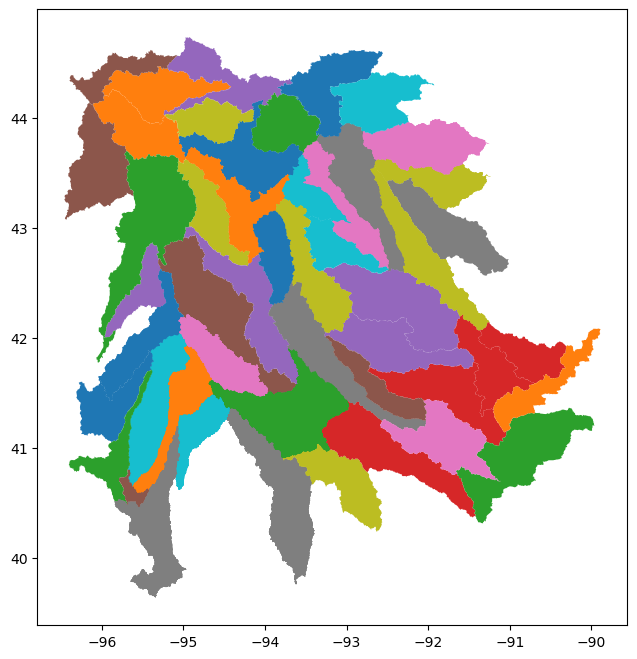

In [13]:
regions_df.plot(column=region_name, figsize=(12,8))

In [14]:
crs_orig = f'EPSG:{regions_df.crs.to_epsg()}'
crs_orig

'EPSG:4326'

In [15]:
x = 'x'
y = 'y'

In [16]:
crs_info = ds.crs
xx = ds.x.values
yy = ds.y.values
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = ccrs.LambertConformal(globe=globe,
                            central_longitude=crs_info.longitude_of_central_meridian, 
                            central_latitude=crs_info.latitude_of_projection_origin,
                            standard_parallels=crs_info.standard_parallel)
print(xx)
print(yy)

[-2732000. -2728000. -2724000. ...  2724000.  2728000.  2732000.]
[-2028000. -2024000. -2020000. ...  2020000.  2024000.  2028000.]


In [17]:
lcc_wkt = lcc.to_wkt()

In [18]:
regions_df = regions_df.to_crs(lcc_wkt)
# print(regions_df)

In [19]:
bboxc = tuple(regions_df.geometry.bounds.values.flatten())
bbox = tuple(regions_df.total_bounds)
bbox

(114866.119809897, 62732.80752809782, 653089.3652002686, 620932.3004259706)

In [20]:
# Take the dataset and slice it and then do temporal aggregation

ds = ds.sel(x=slice(bbox[0],bbox[2]), y=slice(bbox[1],bbox[3])).sel(time=slice('2010-01-01','2020-12-31'))
# print(ds)
# var = 'T2'


var = 'ACRAINLSM'

ds_subset_daily = ds.resample(time="M", loffset="M").sum()

C:\Users\adi10136\AppData\Local\Temp\ipykernel_1748\774525306.py:10: FutureWarning: Following pandas, the `loffset` parameter to resample will be deprecated in a future version of xarray.  Switch to using time offset arithmetic.
  ds_subset_daily = ds.resample(time="M", loffset="M").sum()


In [21]:

# Extract all coordinates from the geometries in regions_df
coords = []
for geom in regions_df.geometry:
    if geom.geom_type == 'Polygon':
        coords.extend(np.array(geom.exterior.coords))
    elif geom.geom_type == 'MultiPolygon':
        for part in geom.geoms:  # Corrected part
            coords.extend(np.array(part.exterior.coords))

coords = np.array(coords)
print("Coordinates:", coords)

# Create a mask for selecting data points within the coordinates
x_mask = np.isin(ds['x'], coords[:, 0])
y_mask = np.isin(ds['y'], coords[:, 1])

# Apply the mask to the dataset
ds_sliced = ds.sel(x=ds['x'][x_mask], y=ds['y'][y_mask]).sel(time=slice('2010-01-01', '2020-12-31'))

                                                             
var = 'ACRAINLSM'

ds_subset_daily2 = ds_sliced.resample(time="M", loffset="D").sum()

Coordinates: [[428464.23529302 508841.98253608]
 [428568.41441604 508698.78620877]
 [428634.9684832  508553.0766186 ]
 ...
 [321955.17797216 451460.79757931]
 [322004.87382516 451454.16716903]
 [322077.30480499 451456.36222862]]


C:\Users\adi10136\AppData\Local\Temp\ipykernel_1748\2605766054.py:23: FutureWarning: Following pandas, the `loffset` parameter to resample will be deprecated in a future version of xarray.  Switch to using time offset arithmetic.
  ds_subset_daily2 = ds_sliced.resample(time="M", loffset="D").sum()


In [22]:
ds_subset_daily2.hvplot.quadmesh(x='lon', y='lat', rasterize=True, 
                             geo=True, tiles='OSM', alpha=0.7, cmap='turbo')

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [lon,lat]   (ACDEWC)

In [23]:
ds_subset_daily.hvplot.quadmesh(x='lon', y='lat', rasterize=True, 
                             geo=True, tiles='OSM', alpha=0.7, cmap='turbo')

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [lon,lat]   (ACDEWC)

In [24]:
grid = ds[[var]].drop(['time', 'lon', 'lat', var]).reset_coords().load()#.sel(time=slice('2016-01-01','2022-01-31'))

In [25]:
grid = grid.cf.add_bounds([x, y])

In [26]:
points = grid.stack(point=(y,x))

In [27]:
def bounds_to_poly(x_bounds, y_bounds):
    return Polygon([
        (x_bounds[0], y_bounds[0]),
        (x_bounds[0], y_bounds[1]),
        (x_bounds[1], y_bounds[1]),
        (x_bounds[1], y_bounds[0])
    ])


In [28]:
%%time
boxes = xr.apply_ufunc(
    bounds_to_poly,
    points.x_bounds,
    points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)

CPU times: total: 797 ms
Wall time: 817 ms


In [29]:
grid_df = gp.GeoDataFrame(
    data={"geometry": boxes.values, "y": boxes[y], "x": boxes[x]},
    index=boxes.indexes["point"],
    crs=lcc_wkt
)

In [30]:
crs_area = "EPSG:6931"

regions_df = regions_df.to_crs(crs_area)
grid_df = grid_df.to_crs(crs_area)

grid_df.crs



<Projected CRS: EPSG:6931>
Name: WGS 84 / NSIDC EASE-Grid 2.0 North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere.
- bounds: (-180.0, 0.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 North
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
overlay = grid_df.overlay(regions_df, keep_geom_type=True)

In [32]:
sparsity = len(overlay) / (len(grid_df) * len(regions_df))
sparsity

0.01528531603800421

In [33]:
overlay.geometry.area.groupby(overlay[region_name]).sum().nlargest(10)/1e6
regions_df.geometry.area.groupby(regions_df[region_name]).sum().nlargest(10)

name
Lake Red Rock       4.428396e+10
Thompson            2.280482e+10
East Nishnabotna    1.785113e+10
Tarkio-Wolf         1.762129e+10
West Nishnabotna    1.710983e+10
South Raccoon       1.472241e+10
Upper Cedar         1.308892e+10
Upper Iowa          1.271931e+10
West Nodaway        1.235462e+10
South Skunk         9.549496e+09
dtype: float64

In [34]:
grid_cell_fraction = overlay.geometry.area.groupby(overlay[region_name]).transform(lambda x: x / x.sum())
grid_cell_fraction

0        0.000057
1        0.000367
2        0.000366
3        0.000464
4        0.000937
           ...   
26862    0.000331
26863    0.000071
26864    0.000090
26865    0.000588
26866    0.000908
Length: 26867, dtype: float64

In [35]:
grid_cell_fraction.groupby(overlay[region_name]).sum()

name
Big Papillion-Mosquito    1.0
Blue Earth                1.0
Boone                     1.0
Boyer                     1.0
Cannon                    1.0
Copperas-Duck             1.0
Cottonwood                1.0
Des Moines Headwaters     1.0
East Fork Des Moines      1.0
East Nishnabotna          1.0
Flint-Henderson           1.0
Keg-Weeping Water         1.0
Lake Red Rock             1.0
Le Sueur                  1.0
Little Sioux              1.0
Lower Cedar               1.0
Lower Des Moines          1.0
Lower Iowa                1.0
Lower Wapsipinicon        1.0
Maple                     1.0
Middle Cedar              1.0
Middle Des Moines         1.0
Middle Iowa               1.0
Middle Minnesota          1.0
Nishnabotna               1.0
North Raccoon             1.0
North Skunk               1.0
Redwood                   1.0
Rock                      1.0
Root                      1.0
Shell Rock                1.0
Skunk                     1.0
South Raccoon             1.0
South

In [36]:
multi_index = overlay.set_index([y, x, region_name]).index

In [37]:
df_weights = pd.DataFrame({"weights": grid_cell_fraction.values}, index=multi_index)
df_weights

weights
y        x        name                 
64000.0  208000.0 Tarkio-Wolf  0.000057
         212000.0 Tarkio-Wolf  0.000367
         216000.0 Tarkio-Wolf  0.000366
68000.0  208000.0 Tarkio-Wolf  0.000464
         212000.0 Tarkio-Wolf  0.000937
...                                 ...
604000.0 204000.0 Redwood      0.000331
         208000.0 Redwood      0.000071
         212000.0 Redwood      0.000090
         220000.0 Redwood      0.000588
608000.0 196000.0 Redwood      0.000908

[26867 rows x 1 columns]

In [38]:
ds_weights = xr.Dataset(df_weights)

In [39]:
weights_sparse = ds_weights.unstack(sparse=True, fill_value=0.).weights

In [40]:
def apply_weights_matmul_sparse(weights, data):
    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))
    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

In [41]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    var_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        weights_sparse,
        ds[var],
        join="left",
        input_core_dims=[[y, x, region_name], [y, x]],
        output_core_dims=[[region_name]],
        dask="parallelized",
        dask_gufunc_kwargs=dict(meta=[np.ndarray((0,))])
    )
    
var_regridded.compute()

CPU times: total: 39.6 s
Wall time: 1min


<xarray.DataArray (time: 4018, name: 48)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.93345836e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.28214030e-10],
       [1.13799696e-12, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.36623259e-07],
       ...,
       [1.80059585e-01, 2.71086940e-07, 4.47317184e-06, ...,
        6.40428836e-01, 3.71267167e-07, 1.92444638e-08],
       [1.16687711e-01, 7.25887820e-03, 9.69818723e-02, ...,
        4.39308851e-01, 5.35526313e-02, 5.19348379e-03],
       [6.36104946e-06, 1.00655175e-04, 1.31108215e-04, ...,
        5.05237252e-06, 1.79901803e-05, 7.02599013e-05]])
Coordinates:
  * name     (name) object 'Big Papillion-Mosquito' 'Blue Earth' ... 'Zumbro'
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31

In [42]:
var_regridded

<xarray.DataArray (time: 4018, name: 48)>
dask.array<transpose, shape=(4018, 48), dtype=float64, chunksize=(36, 48), chunktype=numpy.ndarray>
Coordinates:
  * name     (name) object 'Big Papillion-Mosquito' 'Blue Earth' ... 'Zumbro'
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31

In [ ]:
# df_mean = var_regridded.to_pandas().sum()
# .sel(name=['Upper Cedar','Upper Iowa'])
df_mean = var_regridded.resample(time="Y").sum().to_pandas().mean()
df_mean.name = var
df_mean = pd.DataFrame(df_mean).reset_index()
print(df_mean.columns)

In [ ]:
print(regions_df.columns)

In [ ]:
merged = pd.merge(regions_df, df_mean)

# # Check the merged DataFrame
# print(merged.head())

In [ ]:
crs_geo = 'EPSG:4326'

merged_geo = merged.to_crs(crs_geo)

In [ ]:
# Plot all pixels

# CartoDark', 'CartoEco', 'CartoLight', 'CartoMidnight', 'EsriAntarcticImagery', 'EsriArcticImagery', 'EsriArcticOceanBase', 'EsriArcticOceanReference', 'EsriDelormeWorldBaseMap', 'EsriImagery', 'EsriNatGeo', 'EsriOceanBase', 'EsriOceanReference', 'EsriReference', 'EsriTerrain', 'EsriUSATopo', 'EsriWorldBoundariesAndPlaces', 'EsriWorldBoundariesAndPlacesAlternate', 'EsriWorldDarkGrayBase', 'EsriWorldDarkGrayReference', 'EsriWorldHillshade', 'EsriWorldHillshadeDark', 'EsriWorldLightGrayBase', 'EsriWorldLightGrayReference', 'EsriWorldNavigationCharts', 'EsriWorldPhysical', 'EsriWorldShadedRelief', 'EsriWorldStreetMap', 'EsriWorldTopo', 'EsriWorldTransportation', 'OSM', 'OpenTopoMap'
merged_geo.hvplot(c=var, geo=True, cmap='viridis_r', frame_width=600, tiles='EsriWorldTopo', title='Annual average precipitation in mm (2010-2020) CONUS404', alpha=0.5)


In [ ]:
ds_var_Annual = var_regridded.sel(name=['Upper Cedar','Upper Iowa','Turkey']).resample(time="YS").sum().to_dataset(region_name)
ds_var_Annual.hvplot(x='time', grid=True, frame_width=1000)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import ee
import json
import geemap
import folium
from PIL import Image
import io
import ipywidgets as widgets
from ipyleaflet import Map, GeoJSON, Marker
import base64
from io import BytesIO
import geemap.geemap as geemap

In [ ]:
# Authenticate Earth Engine using your Google Account
ee.Authenticate()
ee.Initialize()